# What Worked?

* Hyperparameter tuning
* Feature Engineering such as concatenation,aggregation, binning
* Data cleaning steps and most pertinent of them were removing duplicates[more reliable CV] and confusing rows
* Xgboost and CatBoost
* Treating Annual Premium and Vintage as categorical features in catboost
* Blending CatBoost and XgBoost **[Blended probablities from 125 CB Models and 125 XgB models]**


# What didn't Work?

* NN and LGBM
* Class balancing via oversampler,undersampler,TomkeLinks etc and via hardcoding class weights parameter in individual algorithm


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

/kaggle/input/avcrosssell/train.csv
/kaggle/input/avcrosssell/test.csv
/kaggle/input/avcrosssell/sample_submission.csv
/kaggle/input/fast-v2-offline/torchvision-0.7.0-cp37-cp37m-manylinux1_x86_64.whl
/kaggle/input/fast-v2-offline/fastai-2.0.8-py3-none-any.whl
/kaggle/input/fast-v2-offline/dataclasses-0.6-py3-none-any.whl
/kaggle/input/fast-v2-offline/fastcore-1.0.1-py3-none-any.whl
/kaggle/input/fast-v2-offline/fastprogress-1.0.0-py3-none-any.whl
/kaggle/input/fast-v2-offline/torch-1.6.0-cp37-cp37m-manylinux1_x86_64.whl


In [2]:
train_data = pd.read_csv('/kaggle/input/avcrosssell/train.csv')

print(train_data.shape)

train_data.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
test_data = pd.read_csv('/kaggle/input/avcrosssell/test.csv')

print(test_data.shape)

test_data.head()

(127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [4]:
x = train_data[~train_data.iloc[:,1:].duplicated(keep = 'first')]

#reemove confusing ids

train_data = train_data[~train_data.id.isin(x[x.iloc[:,1:-1].duplicated(keep = False)].id)]

In [5]:
def nullColumns(train_data):
    
    list_of_nullcolumns =[]
    
    for column in train_data.columns:
        
        total= train_data[column].isna().sum()
        
        try:
            
            if total !=0:
                
                print('Total Na values is {0} for column {1}' .format(total, column))
                
                list_of_nullcolumns.append(column)
        
        except:
            
            print(column,"-----",total)
    
    print('\n')
    
    return list_of_nullcolumns


def percentMissingFeature(data):
    
    data_na = (data.isnull().sum() / len(data)) * 100
    
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    
    return data_na


def plotMissingFeature(data_na):
    
    f, ax = plt.subplots(figsize=(15, 12))
    
    plt.xticks(rotation='90')
    
    if(data_na.empty ==False):
        
        sns.barplot(x=data_na.index, y=data_na)
        
        plt.xlabel('Features', fontsize=15)
        
        plt.ylabel('Percent of missing values', fontsize=15)
        
        plt.title('Percent missing data by feature', fontsize=15)

In [6]:
print('train data')

print(nullColumns(train_data))

print(percentMissingFeature(train_data))

print('\n')

print('test_data')

print(nullColumns(test_data))

print(percentMissingFeature(test_data))

train data


[]
Series([], dtype: float64)


test_data


[]
Series([], dtype: float64)


In [7]:
train_data.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000
mean,190551.691210,38.821301,0.997869,26.387934,0.458338,30572.161293,112.039449,154.347871,0.122458
std,110016.408515,15.512765,0.046116,13.230202,0.498262,17209.241144,54.202864,83.669945,0.327815
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95275.500000,25.000000,1.000000,15.000000,0.000000,24412.000000,29.000000,82.000000,0.000000
50%,190552.000000,36.000000,1.000000,28.000000,0.000000,31673.000000,133.000000,154.000000,0.000000
75%,285826.500000,49.000000,1.000000,35.000000,1.000000,39405.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


Text(0.5, 1.0, 'Response')

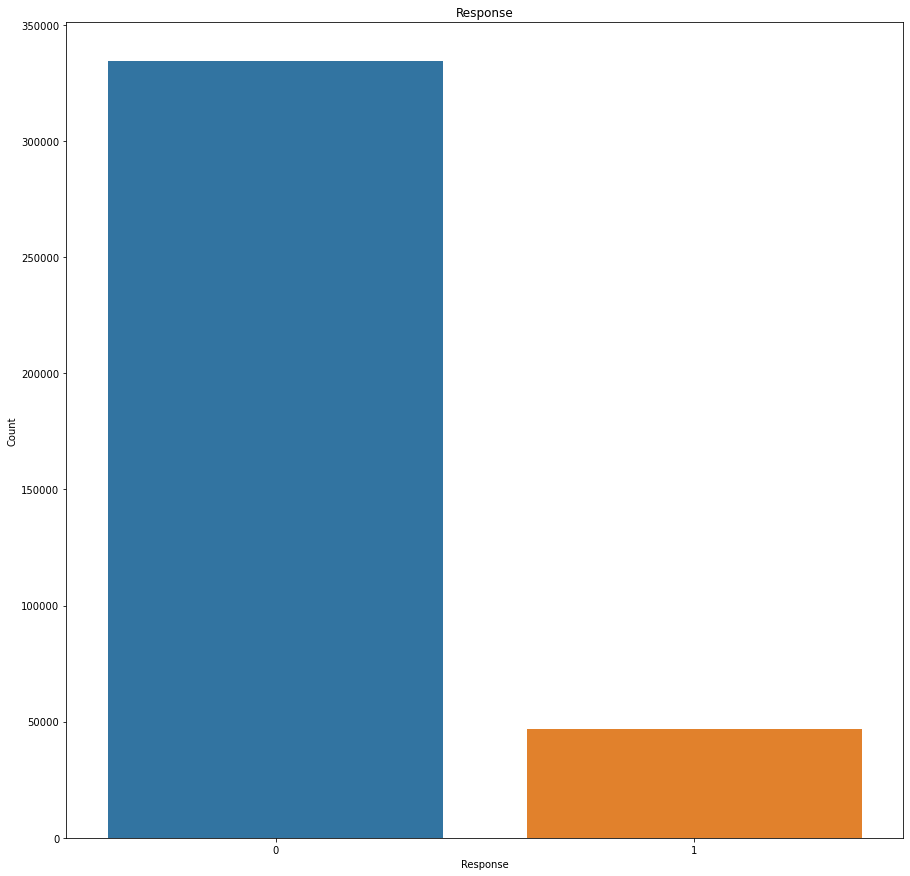

In [8]:
response = train_data.loc[:,"Response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(response.index , response.values).set_title('Response')

In [9]:
response

0    334346
1     46657
Name: Count, dtype: int64

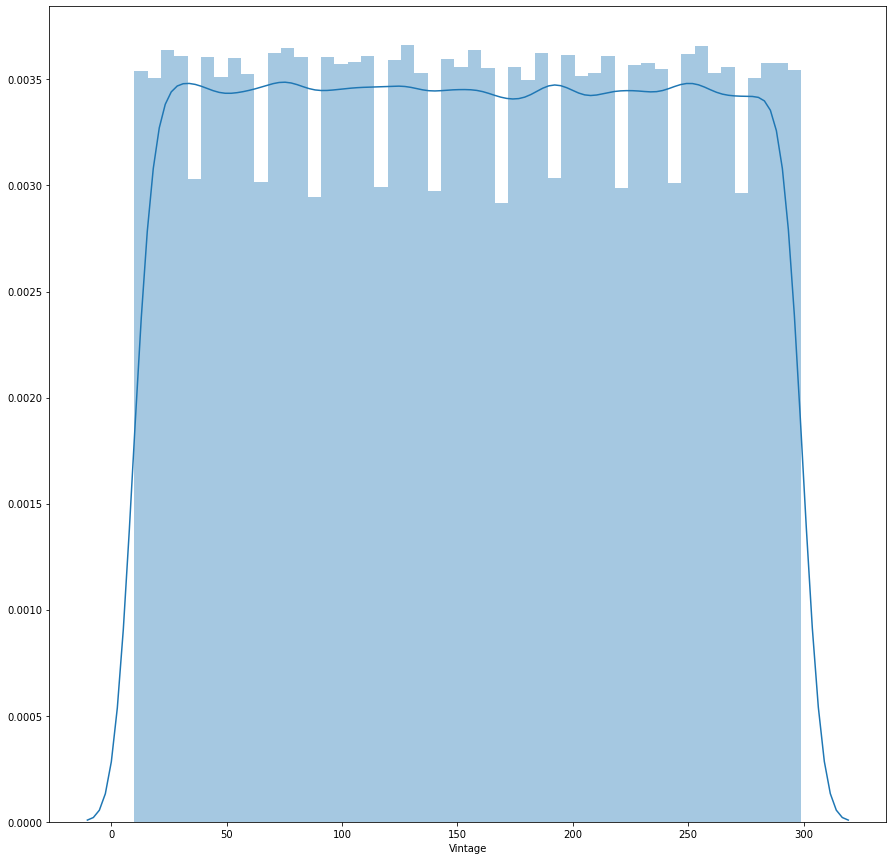

In [10]:
sns.distplot(train_data['Vintage'])

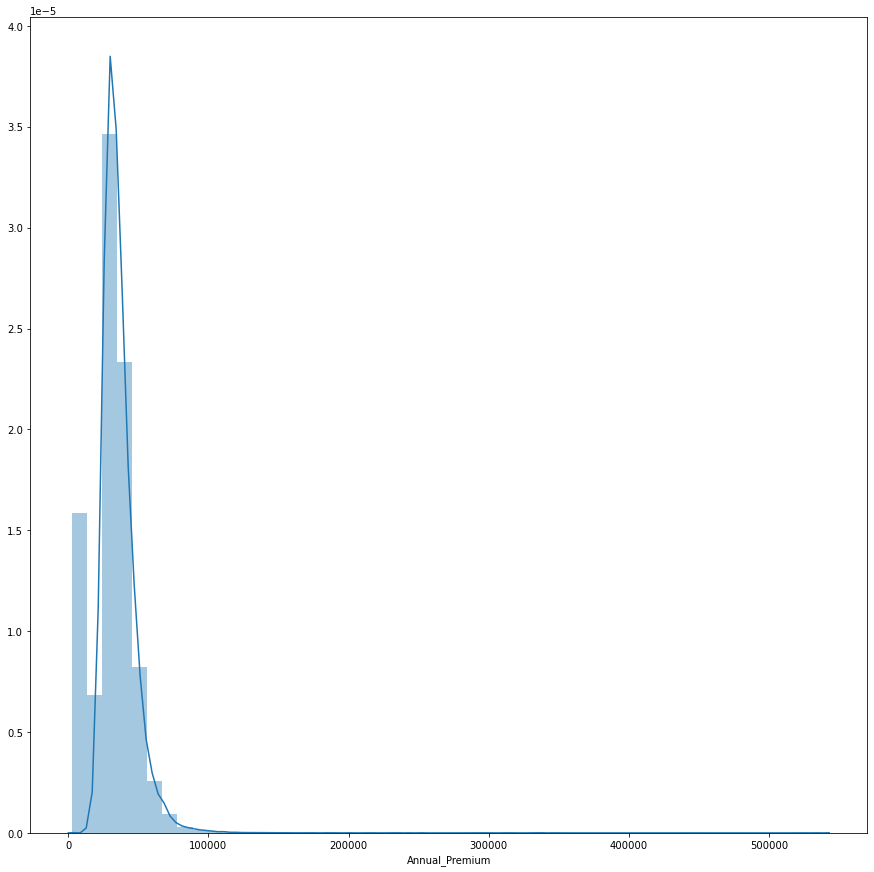

In [11]:
sns.distplot(train_data['Annual_Premium'])

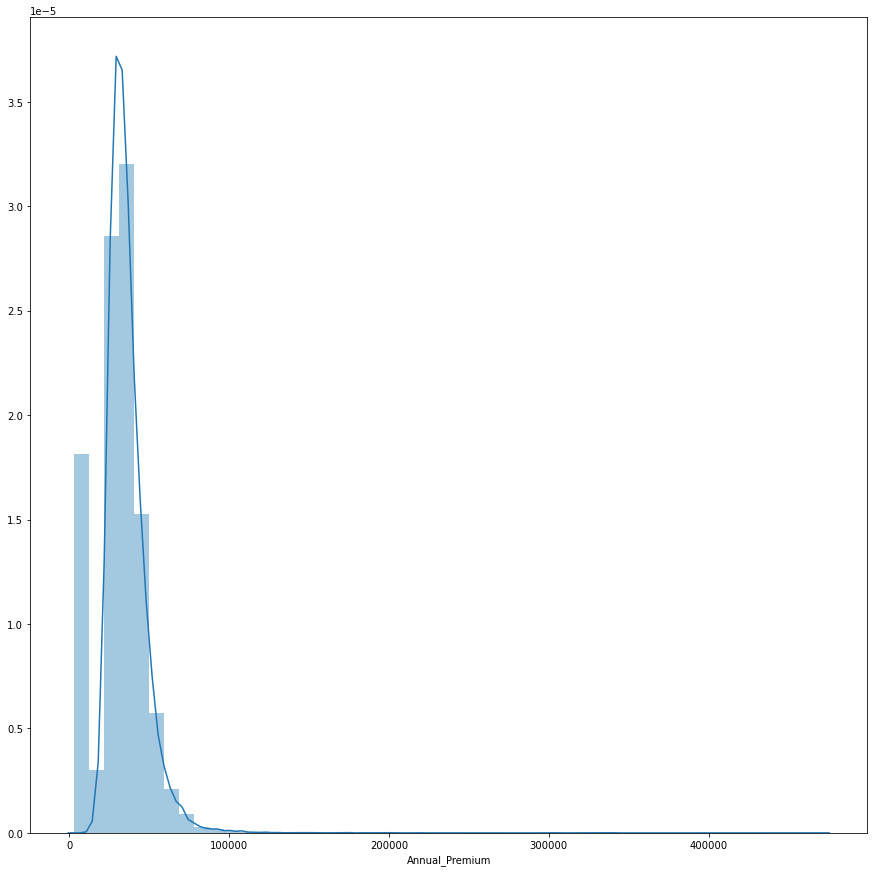

In [12]:
sns.distplot(test_data['Annual_Premium'])

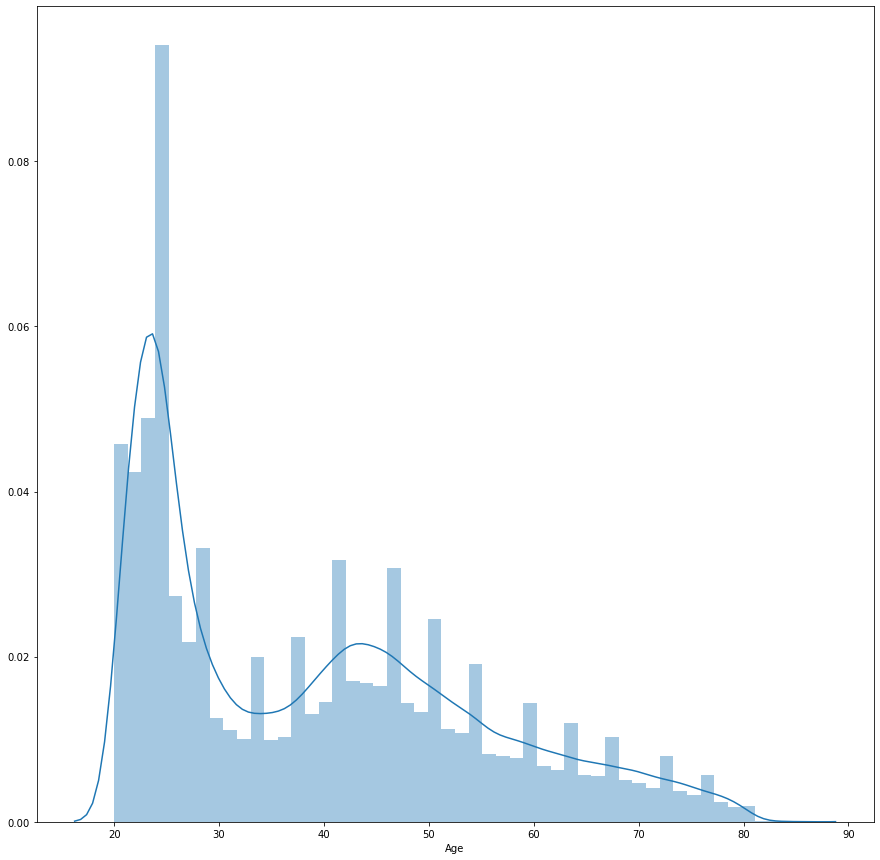

In [13]:
sns.distplot(train_data['Age'])

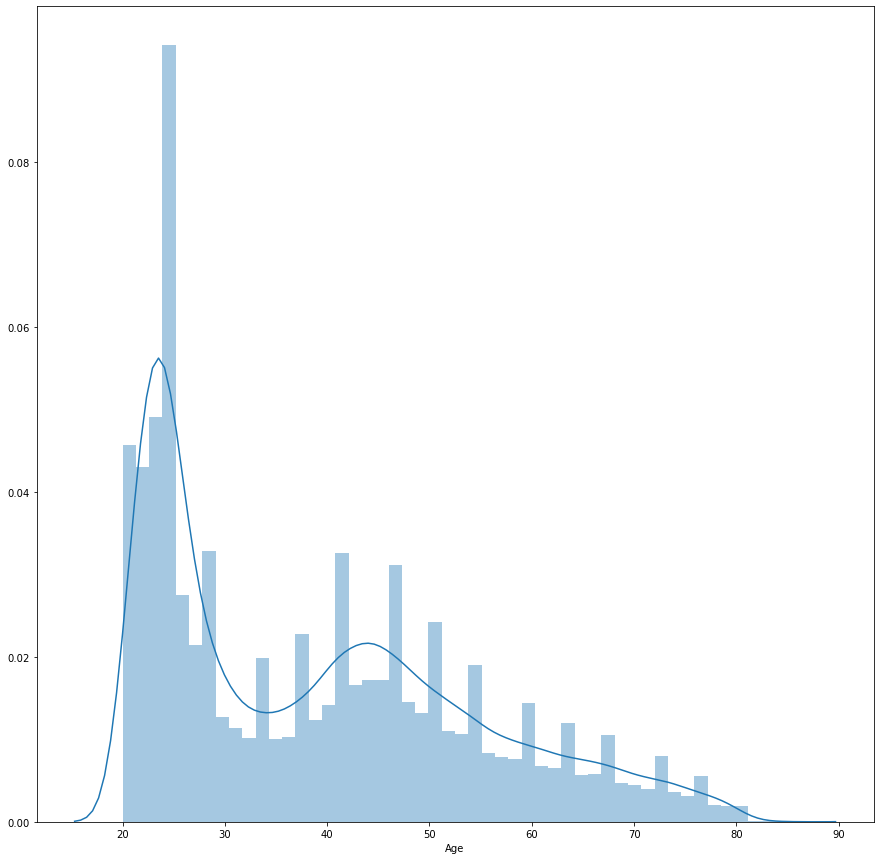

In [14]:
sns.distplot(test_data['Age'])

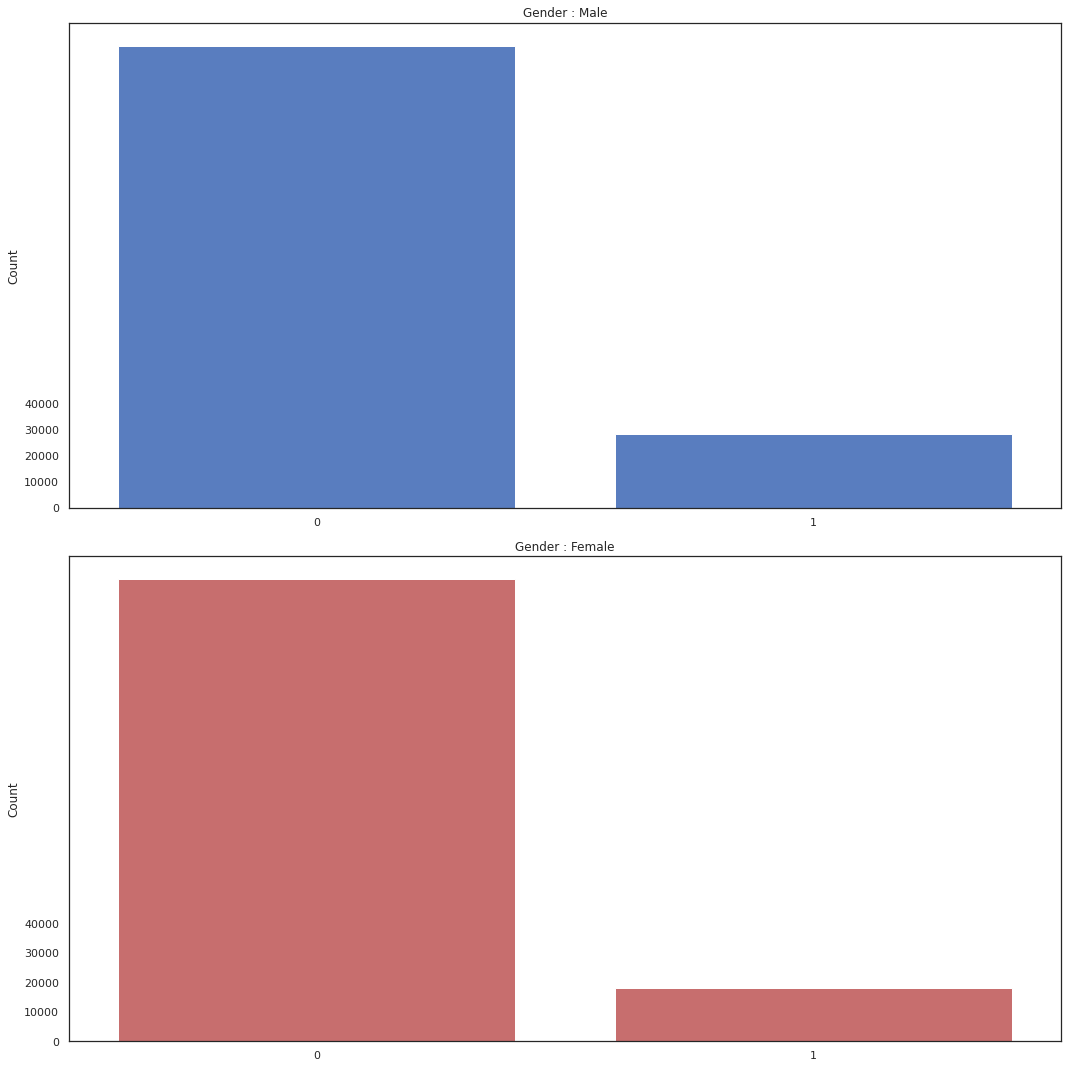

In [15]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(15, 15))

male = train_data[train_data['Gender'] =='Male']["Response"].value_counts().rename('Count')

female = train_data[train_data['Gender'] =='Female']["Response"].value_counts().rename('Count')

sns.barplot(male.index,male,  color="b", ax=axes[0]).set_title('Gender : Male')

sns.barplot(female.index,female,   color="r", ax=axes[1]).set_title('Gender : Female')

plt.setp(axes, yticks = np.arange(0,50000,10000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=0)

plt.tight_layout()

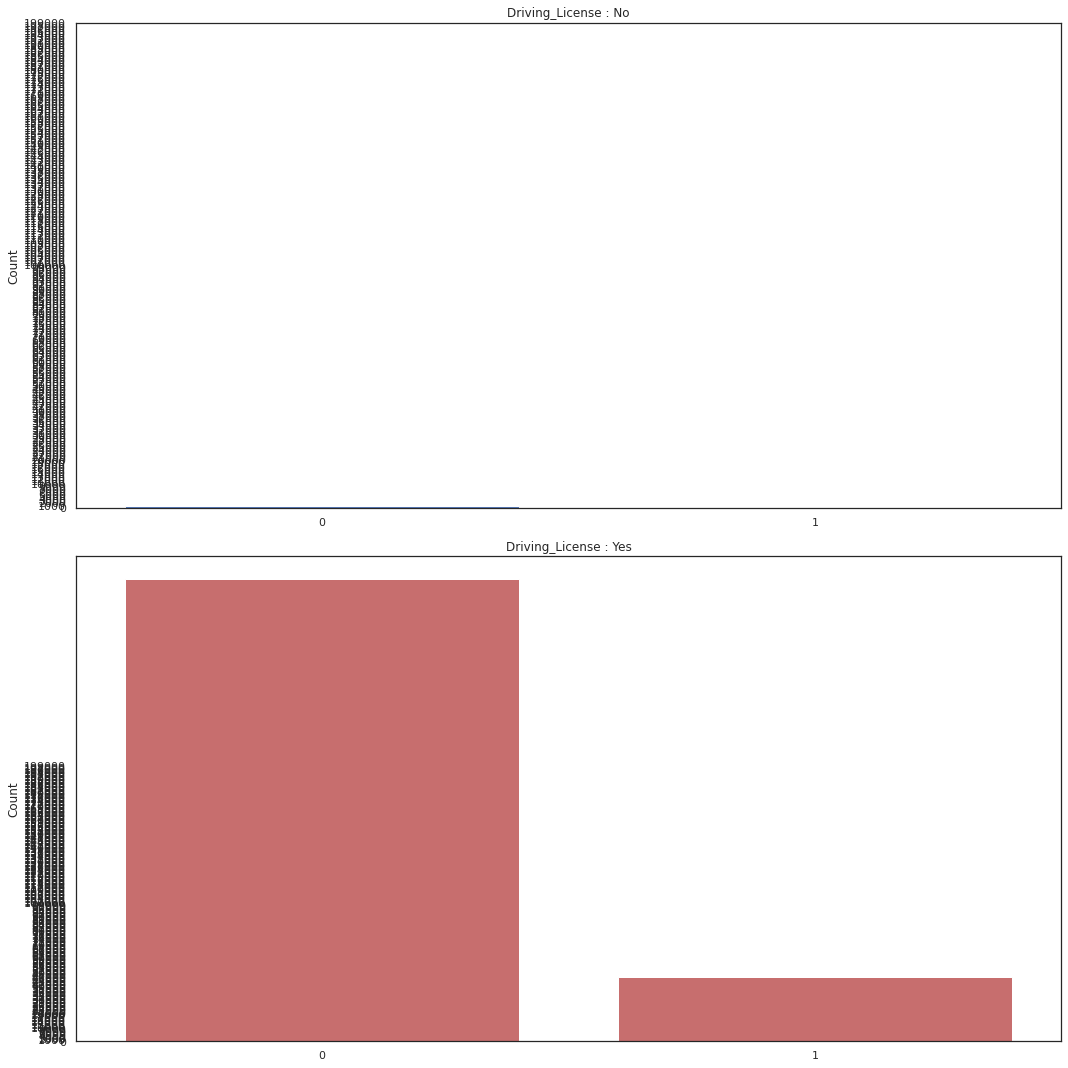

In [16]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(15, 15))

dl0 = train_data[train_data['Driving_License'] ==0]["Response"].value_counts().rename('Count')

dl1 = train_data[train_data['Driving_License'] ==1]["Response"].value_counts().rename('Count')

sns.barplot(dl0.index,dl0,  color="b", ax=axes[0]).set_title('Driving_License : No')

sns.barplot(dl1.index,dl1,   color="r", ax=axes[1]).set_title('Driving_License : Yes')

plt.setp(axes, yticks = np.arange(0,200000,1000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=0)

plt.tight_layout()

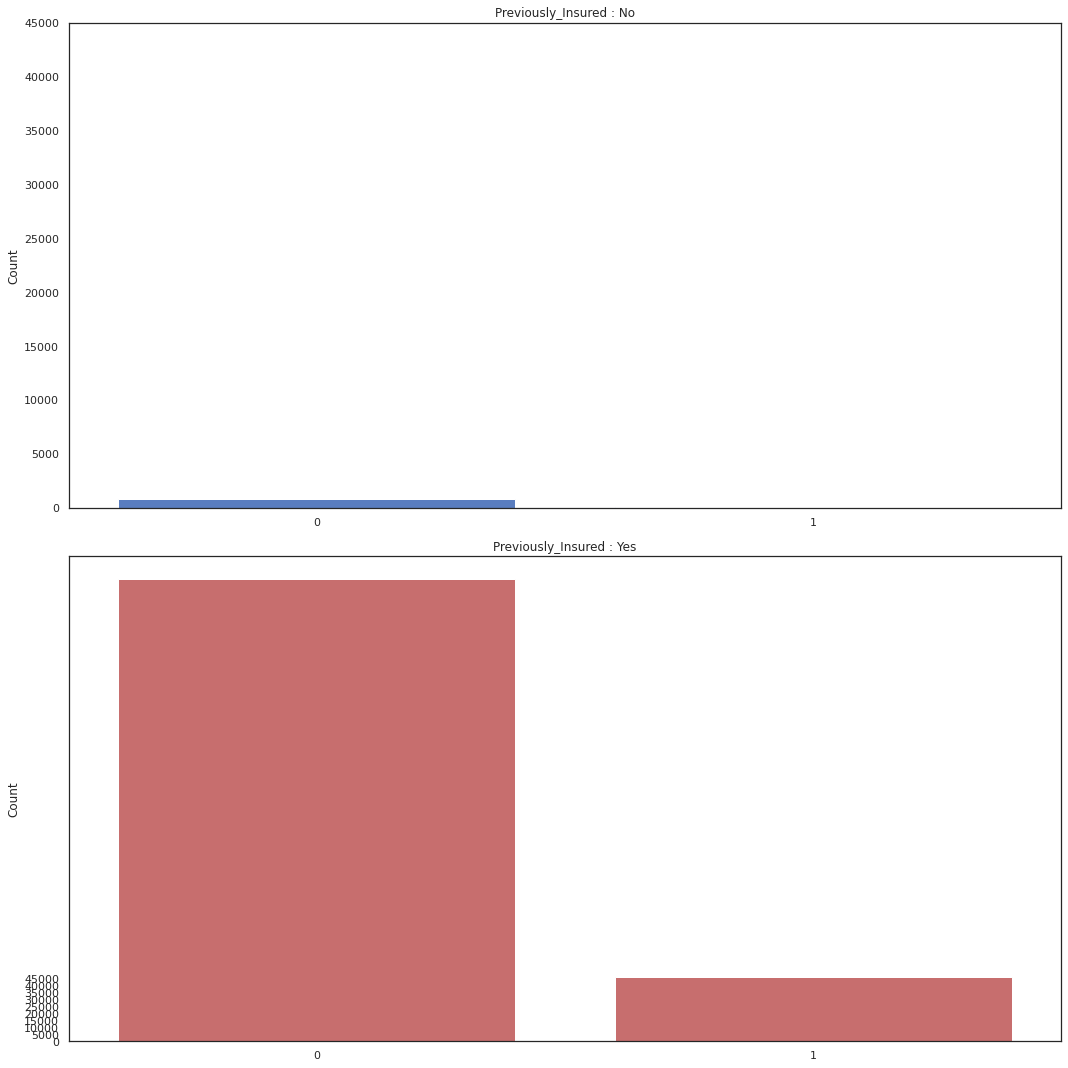

In [17]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(15, 15))

pi0 = train_data[train_data['Previously_Insured'] ==0]["Response"].value_counts().rename('Count')

pi1 = train_data[train_data['Previously_Insured'] ==1]["Response"].value_counts().rename('Count')

sns.barplot(dl0.index,dl0,  color="b", ax=axes[0]).set_title('Previously_Insured : No')

sns.barplot(dl1.index,dl1,   color="r", ax=axes[1]).set_title('Previously_Insured : Yes')

plt.setp(axes, yticks = np.arange(0,50000,5000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=0)

plt.tight_layout()

# Feature Engineering

# Concat Features

In [18]:
train_data['Policy_Region'] = train_data['Policy_Sales_Channel'].astype(str)+'_'+train_data['Region_Code'].astype(str)

test_data['Policy_Region'] = test_data['Policy_Sales_Channel'].astype(str)+'_'+test_data['Region_Code'].astype(str)

train_data['Vehicle_Age_License'] = train_data['Vehicle_Age'].astype(str)+'_'+train_data['Driving_License'].astype(str)

test_data['Vehicle_Age_License'] = test_data['Vehicle_Age'].astype(str)+'_'+test_data['Driving_License'].astype(str)


In [19]:
cat_features = ['Gender','Driving_License','Region_Code','Previously_Insured',
                'Vehicle_Damage','Policy_Sales_Channel','Policy_Region',
                'Vehicle_Age','Vintage','Annual_Premium','Vehicle_Age_License']

cont_features = ['Age']

label = 'Response'

In [20]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        if col!= 'Vehicle_Age':
        
            le = LabelEncoder()

            le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())

            train_df[col] = le.transform(train_df[[col]])

            test_df[col] = le.transform(test_df[[col]])

            le_dict[col] = le
        
    train_df['Vehicle_Age'] = train_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    
    test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    
    return train_df, test_df, le_dict

In [21]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_features)

In [22]:
train_df = train_df[~train_df.Policy_Sales_Channel.isin(list(set(train_df.Policy_Sales_Channel)-set(test_df.Policy_Sales_Channel)))]

#test_df.loc[(test_df.Policy_Sales_Channel.isin(list(set(test_df.Policy_Sales_Channel) - set(train_df.Policy_Sales_Channel)))),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==137),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==136),'Policy_Sales_Channel'] = -1

In [23]:
#Used only for XgBoost and LightGBM
#test_df.loc[(test_df.Annual_Premium.isin(list(set(test_df.Annual_Premium) - set(train_df.Annual_Premium)))),'Annual_Premium'] = -1

In [24]:
train_df['train'] = 1

test_df['train'] = 0

combined_data = pd.concat([train_df,test_df],axis =0).reset_index(drop = True).copy()

# Feature Binning

In [25]:
premium_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

combined_data['Premium_Bins'] =premium_discretizer.fit_transform(combined_data['Annual_Premium'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

combined_data['Age_Bins'] =age_discretizer.fit_transform(combined_data['Age'].values.reshape(-1,1)).astype(int)

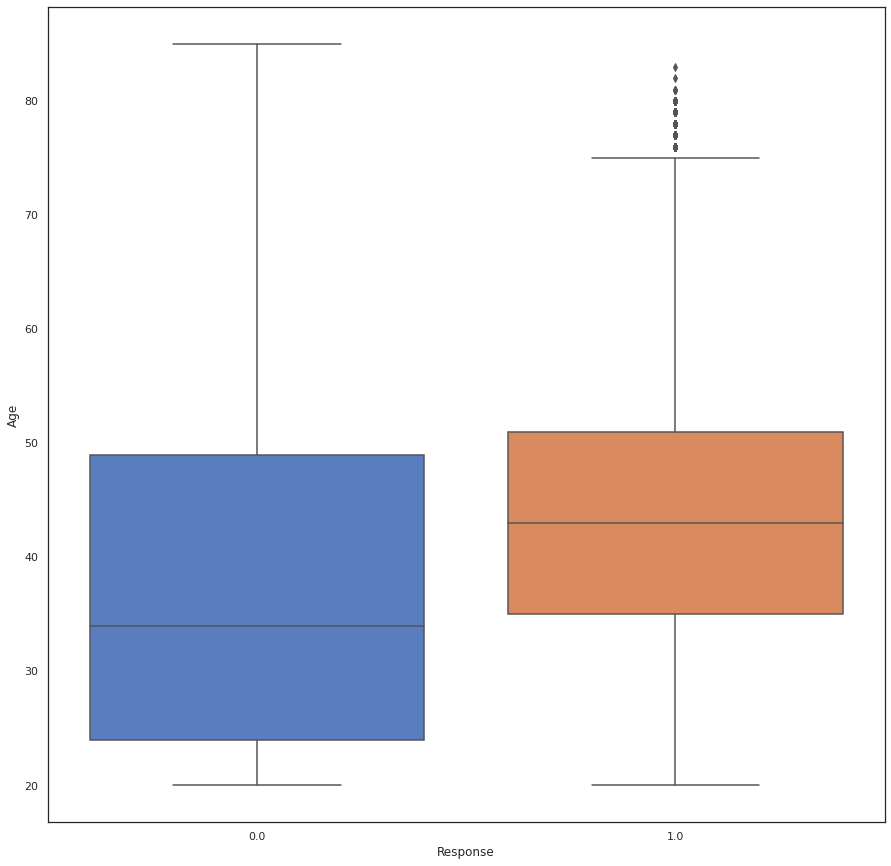

In [26]:
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Age'])

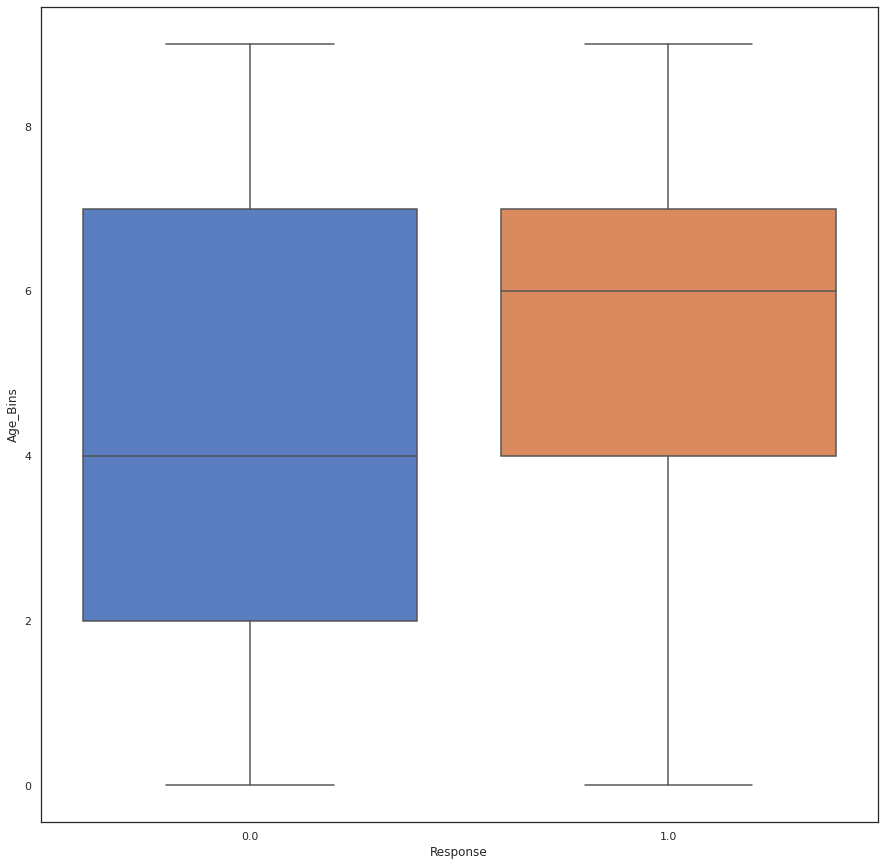

In [27]:
# Age Bin demarcates two classses better(compare the follwing graph with the above one)
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Age_Bins'])

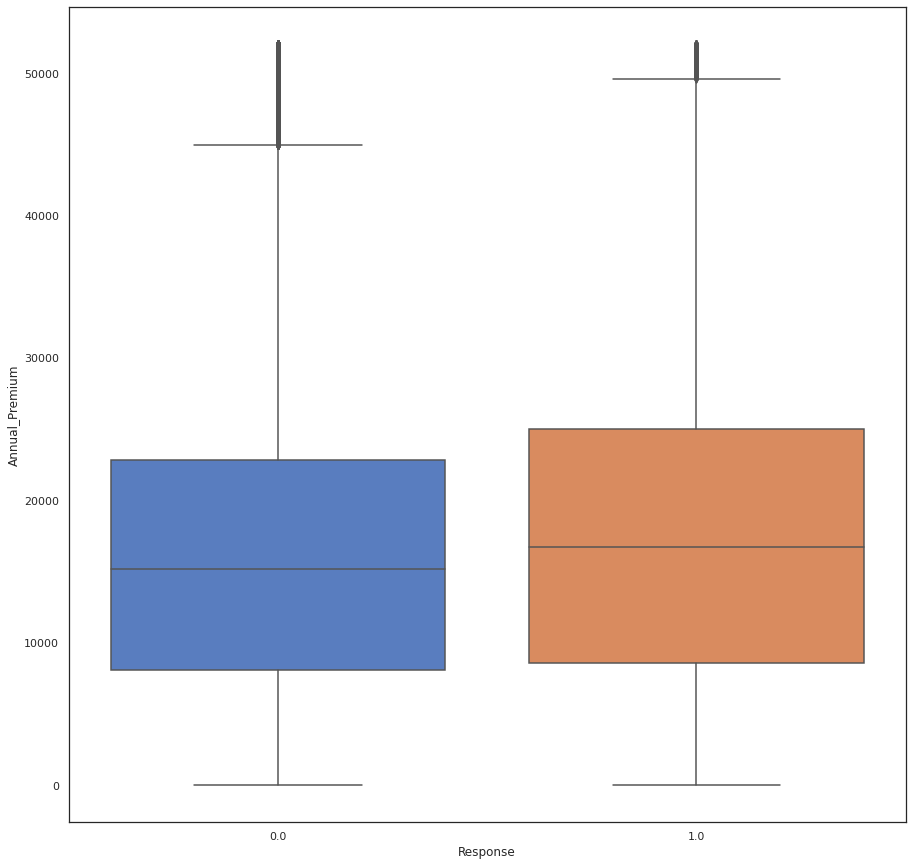

In [28]:
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Annual_Premium'])

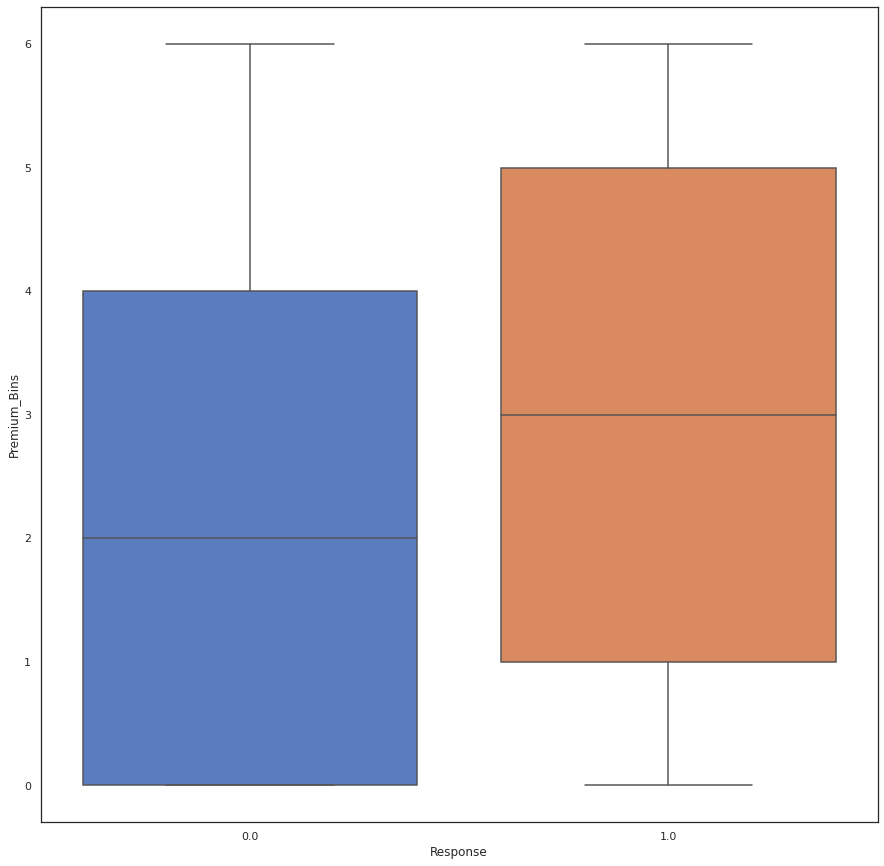

In [29]:
# the same can be seen after binning annual premium
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Premium_Bins'])

# Feature Counts

In [30]:
gender_counts = combined_data['Gender'].value_counts().to_dict()

combined_data['Gender_Counts'] = combined_data['Gender'].map(gender_counts)

region_counts = combined_data['Region_Code'].value_counts().to_dict()

combined_data['Region_counts'] = combined_data['Region_Code'].map(region_counts)

vehicle_age_counts = combined_data['Vehicle_Age'].value_counts().to_dict()

combined_data['Vehicle_Age_Counts'] = combined_data['Vehicle_Age'].map(vehicle_age_counts)

# Feature Aggregations

In [31]:
combined_data['Nunq_Policy_Per_Region'] = combined_data.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique') 

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] = combined_data.groupby('Region_Code')['Annual_Premium'].transform('std').fillna(-1) 

combined_data['Nunq_Region_Per_Premium'] = combined_data.groupby('Annual_Premium')['Region_Code'].transform('nunique')

# 1230.45 can be split into “1230” and “45”. LGBM cannot see these pieces on its own, you need to split them.
combined_data['SDev_Annual_Premium_Per_Region_Code_dec'] = combined_data['SDev_Annual_Premium_Per_Region_Code_int'] %1

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] =combined_data['SDev_Annual_Premium_Per_Region_Code_int'].astype(int)


combined_data['Avg_Policy_Region_Age'] = combined_data.groupby(['Policy_Region'])['Age'].transform('mean')

combined_data['Avg_Policy_Region_Premium'] = combined_data.groupby(['Policy_Region'])['Annual_Premium'].transform('mean') 

combined_data['Avg_Region_Premium'] = combined_data.groupby(['Region_Code'])['Annual_Premium'].transform('mean')

combined_data['Nunq_Premium_Region'] = combined_data.groupby(['Annual_Premium'])['Region_Code'].transform('nunique')

In [32]:
#combined_data['f4'] = combined_data.groupby(['Vehicle_Age'])['Annual_Premium'].transform('max')-combined_data.groupby(['Vehicle_Age'])['Annual_Premium'].transform('min')
#combined_data['f1'] =combined_data['Annual_Premium'] /(combined_data['Vintage']/365)


#combined_data['f2'] = combined_data.groupby(['Premium_Bins'])['Annual_Premium'].transform('max')-combined_data.groupby(['Premium_Bins'])['Annual_Premium'].transform('min')
#combined_data['f2'] = combined_data.groupby(['Annual_Premium'])['Vintage'].transform('nunique')

In [33]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [34]:
# Remove duplicate rows---> More trustworthy CV
cols = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
        'Annual_Premium','Policy_Sales_Channel', 'Vintage']

train_df = train_df[~train_df.loc[:,cols].duplicated(keep = 'first')].reset_index(drop=True)

In [35]:
target = train_df['Response']

train_df = train_df.drop(columns =['train','id','Response'])

test_df = test_df.drop(columns=['train','id','Response'])

In [36]:
test_size = 0.34

train_df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Region_counts,Vehicle_Age_Counts,Nunq_Policy_Per_Region,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium,Nunq_Premium_Region
0,1,44,1,28,0,3,1,24158,24,207,...,141873,21323,121,12413,6,0.243217,51.397261,23898.593057,22686.813178,6
1,1,76,1,3,0,2,0,17240,24,173,...,12345,266897,64,9505,10,0.612352,50.517411,12237.779464,10938.390279,10
2,1,47,1,28,0,3,1,21998,24,17,...,141873,21323,121,12413,11,0.243217,51.397261,23898.593057,22686.813178,11
3,1,21,1,11,1,1,0,12323,147,193,...,12328,219792,53,9800,12,0.449872,25.735264,14232.640980,13361.517278,12
4,0,29,1,41,1,1,0,11200,147,29,...,24399,219792,67,10606,11,0.526628,26.792402,16507.378336,15963.029550,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380702,1,74,1,26,1,2,0,13874,24,78,...,3461,266897,42,8705,12,0.776019,49.357349,16082.953890,14721.989021,12
380703,1,30,1,37,1,1,0,23720,147,121,...,7342,219792,51,8881,4,0.060071,26.166625,14511.676143,14061.525061,4
380704,1,21,1,30,1,1,0,18822,155,151,...,16276,219792,55,7885,10,0.670013,24.784893,9344.776683,11344.417793,10
380705,0,68,1,14,0,3,1,28318,119,64,...,6249,21323,37,9065,4,0.722325,46.691176,12871.089286,11745.857417,4


# Algorithms Used

* **LightGBM**

* **XgBoost**---> used for ensemling

* **CatBoost**---> used for ensemling

* **NN via FastAi**---> Poor CV

# Differentiation based on how each algorithm Splits feature

**Catboost** 
* Uses oblivious decision trees
* Before learning, the possible values of each feature are divided into buckets delimited by threshold values, creating feature-split pairs
* Example for such pairs are: (age, <5), (age, 5-10), (age, >10) and so on. In each level of an oblivious tree, the feature-split pair that brings to the lowest loss (according to a penalty function) is selected and is used for all the level’s nodes.

**LightGBM** 
* Uses gradient-based one-side sampling (GOSS) that selects the split using all the instances with large gradients (i.e., large error) and a random sample of instances with small gradients
* In order to keep the same data distribution when computing the information gain, GOSS introduces a constant multiplier for the data instances with small gradients
* GOSS,thus achieves a good balance between increasing speed by reducing the number of data instances and keeping the accuracy for learned decision trees.

**XGboost** 
* Several methods for selecting the best split
* For example, a histogram-based algorithm that buckets continuous features into discrete bins and uses these bins to find the split value in each node
* This method is faster than the exact greedy algorithm, which linearly enumerates all the possible splits for continuous features, but it is slower compared to GOSS that is used by LightGBM



# Differentiation based on how each algorithm grows leaves



![](https://www.riskified.com/wp-content/uploads/2019/11/inner-image-trees-1-1024x386.png)

* **Catboost** grows a balanced tree.


* **LightGBM** uses leaf-wise (best-first) tree growth
    * It chooses to grow the leaf that minimizes the loss, allowing a growth of an imbalanced tree
    * Because it doesn’t grow level-wise, but leaf-wise, overfitting can  happen when data is small
    * It is therefore important to control the tree depth


* **XGboost** splits up to the specified max_depth hyperparameter
    * It then starts pruning the tree backwards and removes splits beyond which there is no positive gain
    * It uses this approach since sometimes a split of no loss reduction may be followed by a split with loss reduction

# Differentiation based on how each algorithm handles Missing values

* **Catboost** has two modes for processing missing values, “Min” and “Max”.
    * In “Min”, missing values are processed as the minimum value for a feature (they are given a value that is less than all existing values)
    * This way, it is guaranteed that a split that separates missing values from all other values is considered when selecting splits
    * “Max” works exactly the same as “Min”, only with maximum values



* In **LightGBM** and **XGBoost** missing values will be allocated to the side that reduces the loss in each split

# Differentiation based on how each algorithm calculates feature importance

* **Catboost** has two methods
    * The first is “PredictionValuesChange”. For each feature, PredictionValuesChange shows how much, on average, the prediction changes if the feature value changes. A feature would have a greater importance when a change in the feature value causes a big change in the predicted value
    * The second method is “LossFunctionChange”. This type of feature importance can be used for any model, but is particularly useful for ranking models. For each feature the value represents the difference between the loss value of the model with this feature and without it. 



* **LightGBM** and **XGBoost** have two similar methods
    * The first is “Gain” which is the improvement in accuracy (or total gain) brought by a feature to the branches it is on.
    * The second method has a different name in each package: “split” (LightGBM) and “Frequency”/”Weight” (XGBoost). This method calculates the relative number of times a particular feature occurs in all splits of the model’s trees. This method can be biased by categorical features with a large number of categories. 

# Differentiation based on how each algorithm handle categorical feature

* **Catboost** uses a combination of one-hot encoding and an advanced mean encoding
    * For features with low number of categories, it uses one-hot encoding
    * The maximum number of categories for one-hot encoding can be controlled by the one_hot_max_size parameter
    * For the remaining categorical columns, CatBoost uses a method of encoding similar to mean encoding but with an additional mechanism aimed at reducing overfitting
    * Using CatBoost’s categorical encoding comes with a downside of a slower model

* **LightGBM** splits categorical features by partitioning their categories into 2 subsets
    * The basic idea is to sort the categories according to the training objective at each split
    * This method does not necessarily improve the LightGBM model. It has comparable (and sometimes worse) performance than other methods 

* **XGBoost**
doesn’t have an inbuilt method for categorical features. Encoding (one-hot, target encoding, etc.) should be performed by the user.

# Sampling Strategy : Stratified Shuffle Split
![](https://i.stack.imgur.com/AGv9B.png)

# CV LightGBM

In [37]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 251266 rows of holdout = 129441
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.281642	valid_0's auc: 0.85659
[200]	valid_0's binary_logloss: 0.267812	valid_0's auc: 0.85947
[300]	valid_0's binary_logloss: 0.264415	valid_0's auc: 0.859979
[400]	valid_0's binary_logloss: 0.263444	valid_0's auc: 0.860134
[500]	valid_0's binary_logloss: 0.263209	valid_0's auc: 0.860143
Early stopping, best iteration is:
[461]	valid_0's binary_logloss: 0.263275	valid_0's auc: 0.860158
LGB Val OOF AUC= 0.8601581735381363
####################################################################################################
[  1758.58611393  66718.04519629    847.80840653   5053.97154653
 437447.46217728  28690.43852687 511228.53176987   7509.16851091
  44512.01743966   5047.75592691  26283.47188866   7884.61612982
   1162.10515749 

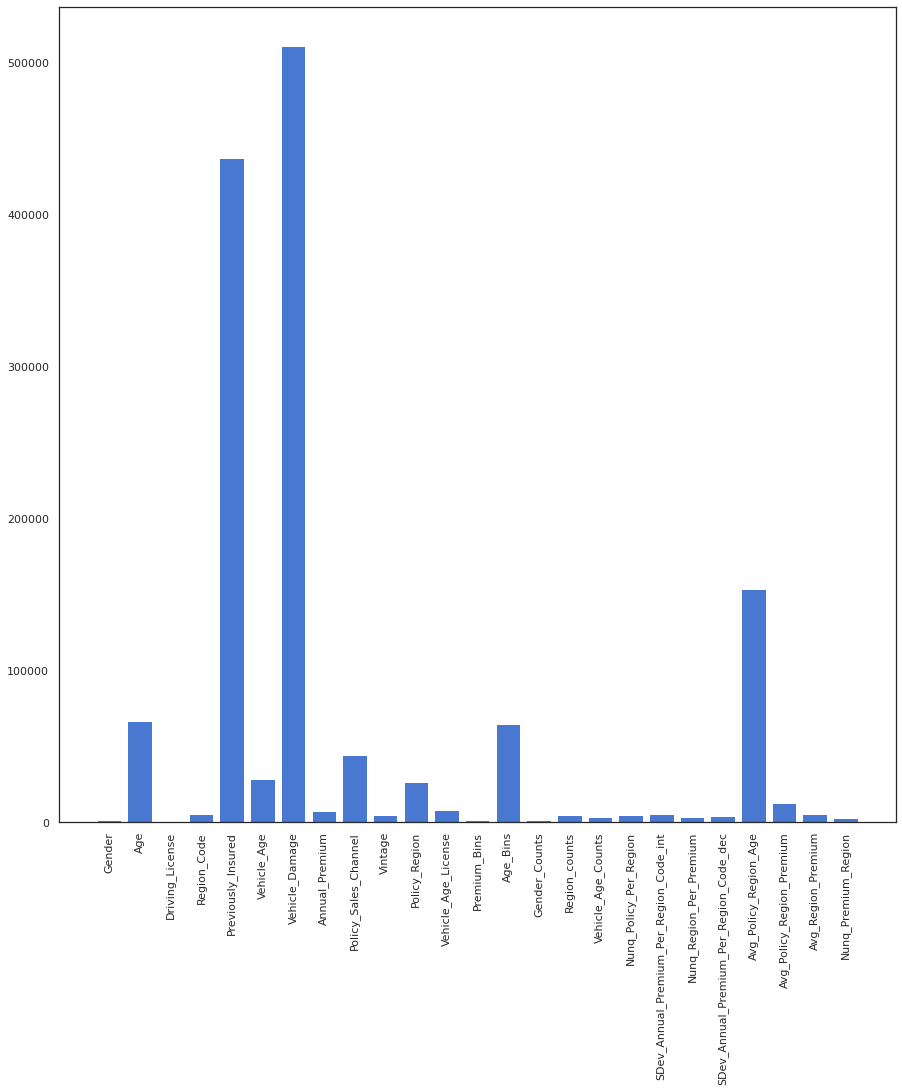

Fold 1
 rows of train = 251266 rows of holdout = 129441
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.28185	valid_0's auc: 0.855833
[200]	valid_0's binary_logloss: 0.268058	valid_0's auc: 0.859049
[300]	valid_0's binary_logloss: 0.264707	valid_0's auc: 0.859631
[400]	valid_0's binary_logloss: 0.26375	valid_0's auc: 0.859835
[500]	valid_0's binary_logloss: 0.26354	valid_0's auc: 0.859838
Early stopping, best iteration is:
[450]	valid_0's binary_logloss: 0.263608	valid_0's auc: 0.859873
LGB Val OOF AUC= 0.8598726475881666
####################################################################################################
Fold 2
 rows of train = 251266 rows of holdout = 129441
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.282308	valid_0's auc: 0.855186
[200]	valid_0's binary_logloss: 0.268578	valid_0's auc: 0.858384
[300]	valid_0's binary_logloss: 0.265277	valid_0's auc: 0.858867
[400]	vali

In [38]:
%%time
##LightGBM

cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage',
                'Annual_Premium','Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

probs_lgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])

    X_train_cv,y_train_cv = train_df.copy(), target.copy()

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = lgb.LGBMClassifier(boosting_type='gbdt',
                                 n_estimators=10000,
                                 max_depth=10,
                                 learning_rate=0.02,
                                 subsample=0.9,
                                 colsample_bytree=0.4,
                                 objective ='binary',
                                 random_state = 1,
                                 importance_type='gain',
                                 reg_alpha=2,
                                 reg_lambda=2
                                 #cat_features=cat_features
                                )        
        
        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['binary_logloss','auc'],
                    early_stopping_rounds=100)
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_lgb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        avg_loss.append(clf.best_score_['valid_0']['binary_logloss'])

        print ('LGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            feature_importance(clf,X_train_cv)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

# CV XGBOOST

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 251266 rows of holdout = 129441
[0]	validation_0-auc:0.73155	validation_0-logloss:0.66945
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85739	validation_0-logloss:0.27664
[200]	validation_0-auc:0.85999	validation_0-logloss:0.26476
[300]	validation_0-auc:0.86019	validation_0-logloss:0.26338
[400]	validation_0-auc:0.86008	validation_0-logloss:0.26324
Stopping. Best iteration:
[368]	validation_0-auc:0.86015	validation_0-logloss:0.26323

XGB Val OOF AUC= 0.8601445296649783
####################################################################################################
[0.00148196 0.00868576 0.00217506 0.00129205 0.47589406 0.00890834
 0.42072144 0.00136369 0.00747729 0.0011678  0.00357578 0.01292557
 0.00098797 0

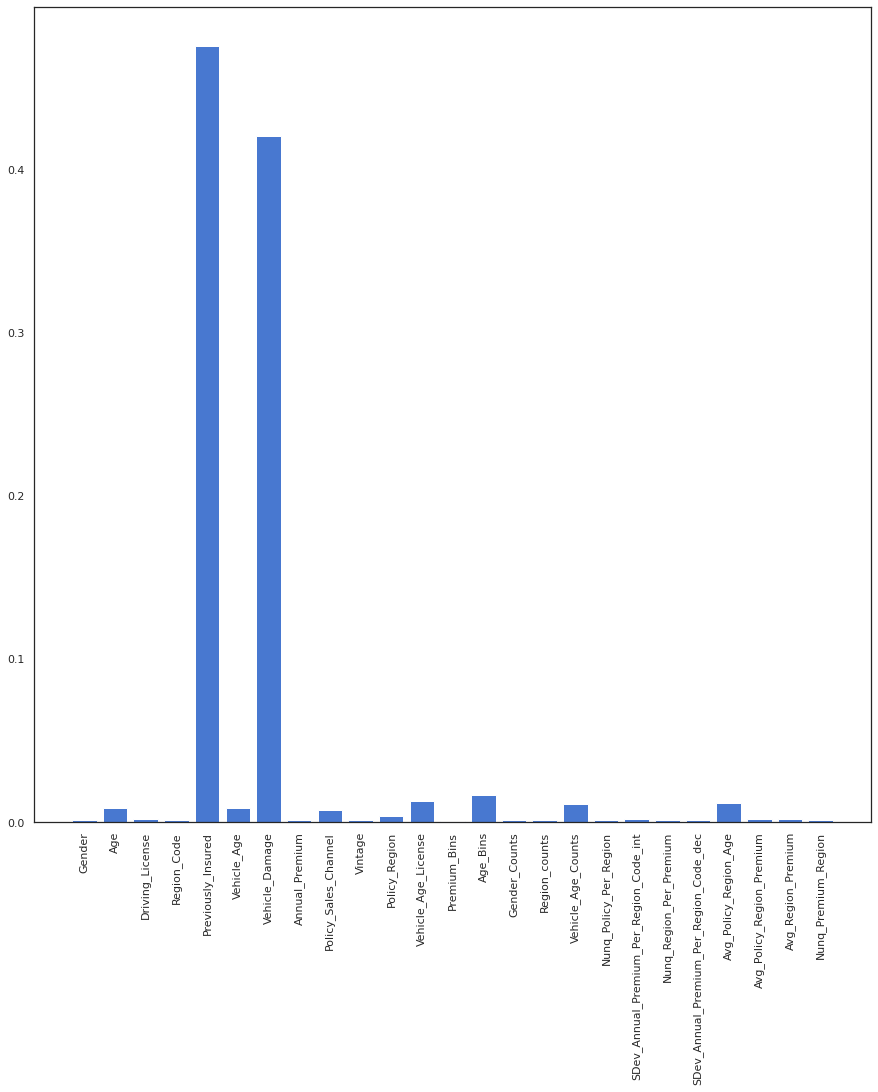

Fold 1
 rows of train = 251266 rows of holdout = 129441
[0]	validation_0-auc:0.73031	validation_0-logloss:0.66942
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85650	validation_0-logloss:0.27690
[200]	validation_0-auc:0.85949	validation_0-logloss:0.26507
[300]	validation_0-auc:0.85970	validation_0-logloss:0.26376
[400]	validation_0-auc:0.85966	validation_0-logloss:0.26358
Stopping. Best iteration:
[368]	validation_0-auc:0.85970	validation_0-logloss:0.26357

XGB Val OOF AUC= 0.8596979724157179
####################################################################################################
Fold 2
 rows of train = 251266 rows of holdout = 129441
[0]	validation_0-auc:0.72789	validation_0-logloss:0.66949
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't i

In [39]:
%%time

##XGBM

probs_xgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = xgb.XGBClassifier(n_estimators=1000,
                                max_depth=6,
                                learning_rate=0.04,
                                subsample=0.9,
                                colsample_bytree=0.35,
                                objective = 'binary:logistic',
                                random_state = 1
                               )        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['auc','logloss'],
                    early_stopping_rounds=50)
        
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_xgb +=clf.predict_proba(test_df)[:,1]

        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)
        
        avg_loss.append(clf.best_score)

        print ('XGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            
            feature_importance(clf,X_train_cv)
            
print("Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

# CV CatBoost

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 251266 rows of holdout = 129441
0:	learn: 0.6546901	test: 0.6547381	best: 0.6547381 (0)	total: 547ms	remaining: 1h 31m 7s
100:	learn: 0.2667418	test: 0.2666153	best: 0.2666153 (100)	total: 41.1s	remaining: 1h 7m 12s
200:	learn: 0.2633722	test: 0.2638318	best: 0.2638318 (200)	total: 1m 22s	remaining: 1h 7m 7s
300:	learn: 0.2621079	test: 0.2634245	best: 0.2634236 (299)	total: 2m 6s	remaining: 1h 7m 55s
400:	learn: 0.2610910	test: 0.2632855	best: 0.2632855 (400)	total: 2m 51s	remaining: 1h 8m 34s
500:	learn: 0.2601945	test: 0.2631967	best: 0.2631967 (500)	total: 3m 41s	remaining: 1h 10m 6s
600:	learn: 0.2593548	test: 0.2631223	best: 0.2631223 (600)	total: 4m 28s	remaining: 1h 10m 6s
700:	learn: 0.2585418	test: 0.2630640	best: 0.2630622 (692)	total: 5m 16s	remaining: 1h 9m 56s
800:	learn: 0.2577751	test: 0.2630421	best: 0.2630421 (800)	total: 6m 4s	remaining

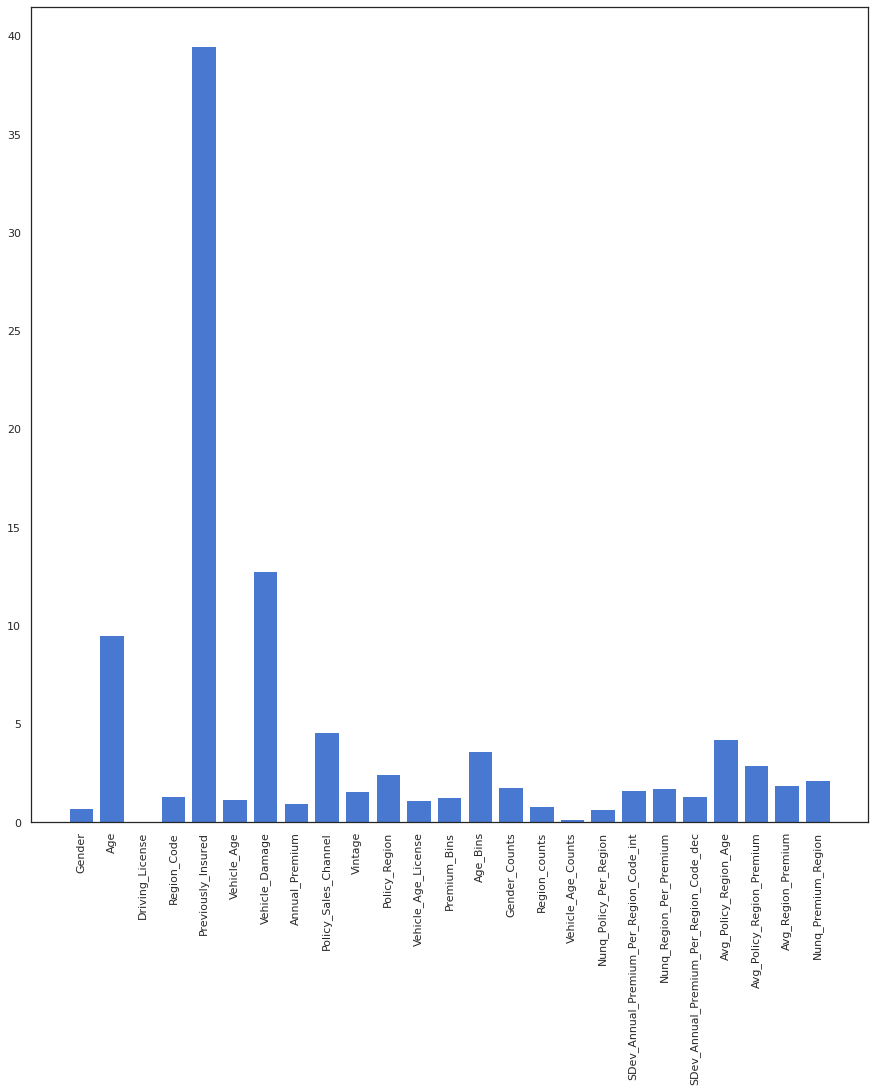

####################################################################################################
Fold 1
 rows of train = 251266 rows of holdout = 129441
0:	learn: 0.6534561	test: 0.6535466	best: 0.6535466 (0)	total: 491ms	remaining: 1h 21m 48s
100:	learn: 0.2665255	test: 0.2668225	best: 0.2668225 (100)	total: 40.4s	remaining: 1h 5m 55s
200:	learn: 0.2632253	test: 0.2641938	best: 0.2641938 (200)	total: 1m 24s	remaining: 1h 8m 23s
300:	learn: 0.2619371	test: 0.2638014	best: 0.2638014 (300)	total: 2m 9s	remaining: 1h 9m 35s
400:	learn: 0.2609366	test: 0.2636791	best: 0.2636791 (400)	total: 2m 58s	remaining: 1h 11m 6s
500:	learn: 0.2600571	test: 0.2635808	best: 0.2635808 (500)	total: 3m 46s	remaining: 1h 11m 27s
600:	learn: 0.2592736	test: 0.2635331	best: 0.2635331 (600)	total: 4m 34s	remaining: 1h 11m 29s
700:	learn: 0.2585227	test: 0.2635153	best: 0.2635153 (700)	total: 5m 22s	remaining: 1h 11m 22s
800:	learn: 0.2577976	test: 0.2634876	best: 0.2634856 (782)	total: 6m 14s	remaining: 1

In [40]:
%%time

##CatBoost

cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage','Annual_Premium',
                'Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

probs_cb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = CatBoostClassifier(iterations=10000,
                                learning_rate=0.02,
                                random_strength=0.1,
                                depth=8,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                leaf_estimation_method='Newton',
                                random_state = 1,
                                cat_features =cat_features,
                                subsample = 0.9,
                                rsm = 0.8
                                )    

        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                   early_stopping_rounds=50,verbose = 100)

        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_cb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        print ('CatBoost Val OOF AUC=',roc)

        avg_loss.append(clf.best_score_['validation']['Logloss'])

        if i==0:
            
            feature_importance(clf,X_train_cv)

        print('#'*100)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

## CV FastAI--->Poor Performance

In [41]:
#!pip uninstall -q fastai -y

#!pip install -q /kaggle/input/fast-v2-offline/dataclasses-0.6-py3-none-any.whl

#!pip install -q /kaggle/input/fast-v2-offline/torch-1.6.0-cp37-cp37m-manylinux1_x86_64.whl

#!pip install -q /kaggle/input/fast-v2-offline/torchvision-0.7.0-cp37-cp37m-manylinux1_x86_64.whl

#!pip install -q /kaggle/input/fast-v2-offline/fastcore-1.0.1-py3-none-any.whl

#!pip install -q /kaggle/input/fast-v2-offline/fastai-2.0.8-py3-none-any.whl

#import fastai

#print('fastai version :', fastai.__version__)

#from fastai import *

#from fastai.layers import *

#from fastai.tabular.all import *

#import torch.nn.functional as F

#import torch

#import torch.nn as nn

#import torch.optim as optim

#from torch.utils.data import Dataset, DataLoader

In [42]:
"""
def categorical_features(df,cat_features,uuid_col):
    
    cat_features_subdf = []
    
    for col in df.columns:
        
        if col in cat_features:
            
            cat_features_subdf.append(col)
            
    return cat_features_subdf


def continuous_features(df,uuid_col,cat_features_subdf):
    
    cont_features_subdf = []
    
    for col in df.columns:
        
        if col not in cat_features_subdf:
            
            cont_features_subdf.append(col)
            
    return cont_features_subdf
    
"""

'\ndef categorical_features(df,cat_features,uuid_col):\n    \n    cat_features_subdf = []\n    \n    for col in df.columns:\n        \n        if col in cat_features:\n            \n            cat_features_subdf.append(col)\n            \n    return cat_features_subdf\n\n\ndef continuous_features(df,uuid_col,cat_features_subdf):\n    \n    cont_features_subdf = []\n    \n    for col in df.columns:\n        \n        if col not in cat_features_subdf:\n            \n            cont_features_subdf.append(col)\n            \n    return cont_features_subdf\n    \n'

In [43]:
""""
class FocalLoss(nn.Module):
    
    def __init__(self, alpha=4, gamma=2, logits=False, reduction = 'mean'):
        
        super(FocalLoss, self).__init__()
       
        self.alpha = alpha
        
        self.gamma = gamma
        
        self.logits = logits
        
        self.reduction = reduction

    def forward(self, inputs, targets):

        targets =targets.type_as(inputs)
        
        if self.logits:
            
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        else:
            
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        
        pt = torch.exp(-BCE_loss)
        
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            
            return F_loss
        
        else:
            
            return torch.mean(F_loss)
            
"""

'"\nclass FocalLoss(nn.Module):\n    \n    def __init__(self, alpha=4, gamma=2, logits=False, reduction = \'mean\'):\n        \n        super(FocalLoss, self).__init__()\n       \n        self.alpha = alpha\n        \n        self.gamma = gamma\n        \n        self.logits = logits\n        \n        self.reduction = reduction\n\n    def forward(self, inputs, targets):\n\n        targets =targets.type_as(inputs)\n        \n        if self.logits:\n            \n            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction=\'none\')\n        \n        else:\n            \n            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction=\'none\')\n        \n        pt = torch.exp(-BCE_loss)\n        \n        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss\n\n        if self.reduction is None:\n            \n            return F_loss\n        \n        else:\n            \n            return torch.mean(F_loss)\n            \n'

In [44]:
"""
%%time

scores = []

avg_loss = []

cat_features = ['Gender','Driving_License','Region_Code','Previously_Insured','Vehicle_Damage','Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage']

cont_features = ['Age','Annual_Premium',]

#custom sklearn metric
roc =  skm_to_fastai(roc_auc_score,axis=0)

#np.random.seed(10)

probs = np.zeros(shape=(len(test_df)))

#seeds = list(np.random.randint(5,500,1))

seeds = [1]

for seed in seeds:
    
    print(' ')

    print('#'*100)

    print('Seed',seed)

    df = train_df.copy().sample(frac = 1.0,axis =1,random_state = seed)

    cat_features_subdf= categorical_features(df,cat_features,'')

    cont_features_subdf = continuous_features(df,'',cat_features_subdf)

    df = pd.concat([df, target], axis=1)

    sssf = StratifiedShuffleSplit(n_splits=1, test_size = 0.35 ,random_state=seed)

    procs = [FillMissing,Categorify, Normalize]

    for i, (idxT, idxV) in enumerate(sssf.split(train_df, target)):


        data = TabularDataLoaders.from_df(df, procs=procs,
                                              cont_names=cont_features_subdf, cat_names=cat_features_subdf,
                                              y_names='Response', valid_idx=idxV, bs=256, val_bs=256)


        learn = tabular_learner(data, y_range=(0,1), layers=[256,128,64],loss_func=BCELossFlat(),metrics= [roc])

        #learn.lr_find()
        
        learn.fit_one_cycle(5, 1e-3)
            
        val_loss, val_roc = learn.validate()
            
        scores.append(val_roc)

        avg_loss.append(val_loss)
        
        test_dl = learn.dls.test_dl(test_df)
        
        sub = learn.get_preds(dl=test_dl)
        
        probs += sub[0].numpy().ravel()
            
        print('#'*100)

print("Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

"""

'\n%%time\n\nscores = []\n\navg_loss = []\n\ncat_features = [\'Gender\',\'Driving_License\',\'Region_Code\',\'Previously_Insured\',\'Vehicle_Damage\',\'Policy_Sales_Channel\',\'Policy_Region\',\'Vehicle_Age\',\'Vintage\']\n\ncont_features = [\'Age\',\'Annual_Premium\',]\n\n#custom sklearn metric\nroc =  skm_to_fastai(roc_auc_score,axis=0)\n\n#np.random.seed(10)\n\nprobs = np.zeros(shape=(len(test_df)))\n\n#seeds = list(np.random.randint(5,500,1))\n\nseeds = [1]\n\nfor seed in seeds:\n    \n    print(\' \')\n\n    print(\'#\'*100)\n\n    print(\'Seed\',seed)\n\n    df = train_df.copy().sample(frac = 1.0,axis =1,random_state = seed)\n\n    cat_features_subdf= categorical_features(df,cat_features,\'\')\n\n    cont_features_subdf = continuous_features(df,\'\',cat_features_subdf)\n\n    df = pd.concat([df, target], axis=1)\n\n    sssf = StratifiedShuffleSplit(n_splits=1, test_size = 0.35 ,random_state=seed)\n\n    procs = [FillMissing,Categorify, Normalize]\n\n    for i, (idxT, idxV) in enu

# Blending

In [45]:
p1 =probs_lgb/5

p2 = probs_cb/5

p3 = probs_xgb/5

In [46]:
submission = pd.read_csv('../input/avcrosssell/sample_submission.csv')

submission['Response'] =  0.7*p2+0.3*p3

In [47]:
submission.to_csv('submission.csv',index =False)

submission.head()

,id,Response
0,381110,0.000563
1,381111,0.301206
2,381112,0.292928
3,381113,0.007399
4,381114,0.000371


In [48]:
np.save('lgb.npy',p1)
np.save('cb.npy',p2)
np.save('xgb.npy',p3)